In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
from scipy.linalg import cholesky, solve_triangular, cho_factor, cho_solve
from scipy.optimize import minimize
from joblib import Parallel, delayed
import re
import os
from threadpoolctl import threadpool_limits

# ============================================================
# 0) Mapping: (a,b) -> (alpha,beta) with alpha,beta >= 0 and alpha+beta < 1
#    alpha = exp(a)/(1+exp(a)+exp(b)), be

output_path_pic = Path(r"C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\Pictures Assignment 2")
output_path_tables = Path(r"C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\latex_tables")
output_path_pic.mkdir(parents=True, exist_ok=True)
output_path_tables.mkdir(parents=True, exist_ok=True)



## Code for linear shrinkage

## Q1.1

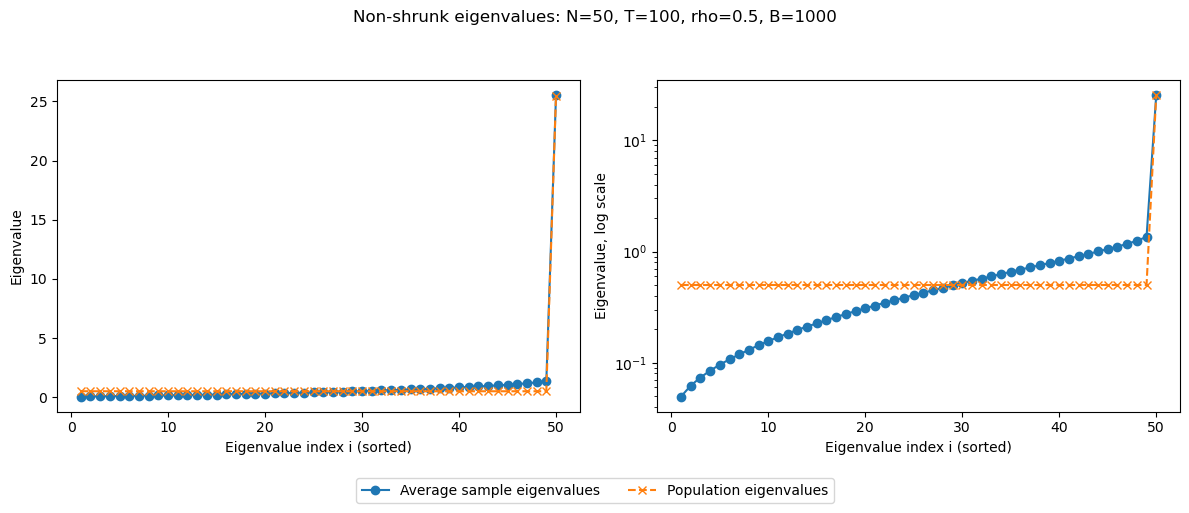

In [2]:
N = 50
T = 100
B = 1000
rho = 0.5
seed = 1827

rng = np.random.default_rng(seed)


#Build equicorrelated Sigma
#Sigma = (1-rho) I + rho 11'
I = np.eye(N)
one = np.ones((N, 1))
Sigma = (1 - rho) * I + rho * (one @ one.T)  # N x N

# Population eigenvalues for equicorrelation:
# (1-rho) with multiplicity N-1, and 1+(N-1)rho once
pop_eigs = np.array([1 - rho] * (N - 1) + [1 + (N - 1) * rho])
pop_eigs.sort()  # ascending


# Monte Carlo loop
eigs_store = np.empty((B, N))

for b in range(B):
    # Simulate Y: T draws of N-dim normal with covariance Sigma
    Y = rng.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T)

    # Sample covariance S = (1/T) (Y-mean)'(Y-mean)
    mean = Y.mean(axis=0)
    Y = Y - mean
    S = (Y.T @ Y) / T

    # Eigenvalues 
    lam = np.linalg.eigvalsh(S)  # already real, sorted ascending, used A.I. to determine which function to use on python
    eigs_store[b, :] = lam


avg_eigs = eigs_store.mean(axis=0)
i = np.arange(1, N + 1)

#plot (I added the plot also in a non-log scale,a nd used A.I. to make the graph more readable)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle(f"Non-shrunk eigenvalues: N={N}, T={T}, rho={rho}, B={B}")

# left panel
axes[0].plot(i, avg_eigs, marker="o", linestyle="-", label="Average sample eigenvalues")
axes[0].plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues")
axes[0].set_xlabel("Eigenvalue index i (sorted)")
axes[0].set_ylabel("Eigenvalue")

# right panel
axes[1].plot(i, avg_eigs, marker="o", linestyle="-", label="Average sample eigenvalues")
axes[1].plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues")
axes[1].set_xlabel("Eigenvalue index i (sorted)")
axes[1].set_ylabel("Eigenvalue, log scale")
axes[1].set_yscale("log")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.06, 1, 0.93])

plt.show()
out_path = output_path_pic / "A2_Fig1.png" 
fig.savefig(out_path, dpi=300, bbox_inches="tight")


## Q1.2

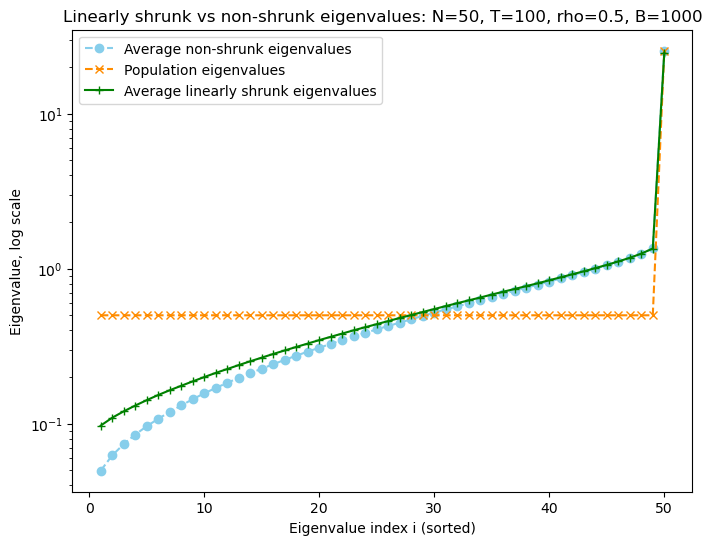

In [3]:
def cov1Para(Y,k = None): #the code to obtain this linear shrinkage function is 
                          #retrieved from the following github repository: https://github.com/pald22/covShrinkage/blob/main/cov1Para.py

    #default setting
    if k is None or math.isnan(k):
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    T,N= Y.shape
    n = T-k                                  
   
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    target=meanvar*np.eye(N)
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    
    pihat = sum(piMat.sum())
    

    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    

    # diagonal part of the parameter that we call rho 
    rho_diag=0;
    
    # off-diagonal part of the parameter that we call rho 
    rho_off=0;
    
    # compute shrinkage intensity
    rhohat=rho_diag+rho_off
    kappahat=(pihat-rhohat)/gammahat
    shrinkage=max(0,min(1,kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    return sigmahat


eigs_linear_store = np.empty((B, N))

for b in range(B):
    # Simulate Y: T draws of N-dim normal with covariance Sigma
    Y = rng.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T)

    # Substitute the sample covariance with the linearly shrunk covariance
    sigmahat = cov1Para(pd.DataFrame(Y), k=None)
    # Eigenvalues 
    lam = np.linalg.eigvalsh(sigmahat)  # already real, sorted ascending, used A.I. to determine which function to use on python
    eigs_linear_store[b, :] = lam   

avg_eigs_linear = eigs_linear_store.mean(axis=0)
i = np.arange(1, N + 1)


fig = plt.figure(figsize=(8, 6))
plt.plot(i, avg_eigs, marker="o", linestyle="--", label="Average non-shrunk eigenvalues", color= "skyblue")
plt.plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues", color = "darkorange")
plt.plot(i, avg_eigs_linear, marker="+", linestyle="-", label="Average linearly shrunk eigenvalues", color = "green")

plt.xlabel("Eigenvalue index i (sorted)")
plt.ylabel("Eigenvalue, log scale")
plt.yscale("log")
plt.legend()
plt.title(f"Linearly shrunk vs non-shrunk eigenvalues: N={N}, T={T}, rho={rho}, B={B}")

plt.show()
out_path = output_path_pic / "A2_Fig2.png" 
fig.savefig(out_path, dpi=300, bbox_inches="tight")



## Q1.3

Estimated covariance matrix from oracle eigenvalues:
 [[0.98908194 0.49571859 0.49845775 ... 0.49516378 0.49642178 0.49599991]
 [0.49571859 0.9929005  0.50050793 ... 0.49695993 0.4986817  0.49828219]
 [0.49845775 0.50050793 0.99780363 ... 0.49921071 0.50091856 0.50049938]
 ...
 [0.49516378 0.49695993 0.49921071 ... 0.99100954 0.4973923  0.4971327 ]
 [0.49642178 0.4986817  0.50091856 ... 0.4973923  0.99385364 0.49872099]
 [0.49599991 0.49828219 0.50049938 ... 0.4971327  0.49872099 0.99341789]]


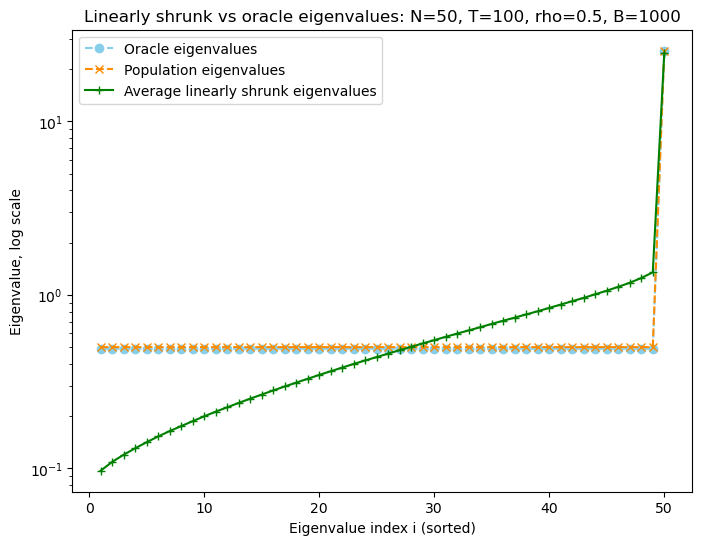

[ 0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377  0.48984377
  0.48984377 25.55211324]
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5 25.5]


In [4]:
oracle_eigs = np.zeros((B, N))
sigma_oracle = np.zeros((B, N, N))

for b in range(B):
    Y = rng.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T)

    Y = Y - Y.mean(axis=0)
    S = (Y.T @ Y) / T

    # --- CHANGE: compute eigenvalues + eigenvectors ---
    lam, U = np.linalg.eigh(S)  # lam ascending, U columns are eigenvectors

    # oracle eigenvalues: replace first N-1 by their mean, keep largest
    oracle_eigs[b, :-1] = np.mean(lam[:-1])
    oracle_eigs[b, -1]  = lam[-1]

    sigma_oracle[b, :, :] = U @ np.diag(oracle_eigs[b, :]) @ U.T

avg_eigs_oracle = oracle_eigs.mean(axis=0)
est_sigma_oracle = sigma_oracle.mean(axis=0)
i = np.arange(1, N + 1)

print("Estimated covariance matrix from oracle eigenvalues:\n", est_sigma_oracle)

fig = plt.figure(figsize=(8, 6))
plt.plot(i, avg_eigs_oracle, marker="o", linestyle="--", label="Oracle eigenvalues", color="skyblue")
plt.plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues", color="darkorange")
plt.plot(i, avg_eigs_linear, marker="+", linestyle="-", label="Average linearly shrunk eigenvalues", color="green")
plt.xlabel("Eigenvalue index i (sorted)")
plt.ylabel("Eigenvalue, log scale")
plt.yscale("log")
plt.legend()
plt.title(f"Linearly shrunk vs oracle eigenvalues: N={N}, T={T}, rho={rho}, B={B}")

out_path = output_path_pic / "A2_Fig3.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(avg_eigs_oracle)
print(pop_eigs)


## Q1.4

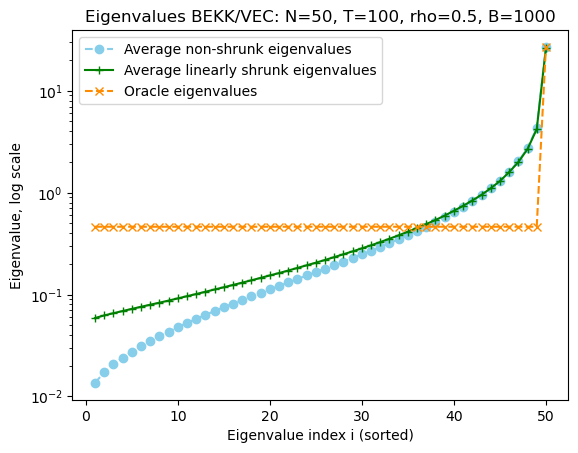

Saved to: C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\latex_tables


In [ ]:
import os
import numpy as np
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from joblib import Parallel, delayed
from threadpoolctl import threadpool_limits

# ============================================================
# 0) Mapping: (a,b) -> (alpha,beta) with alpha,beta >= 0 and alpha+beta < 1
#    alpha = exp(a)/(1+exp(a)+exp(b)), beta = exp(b)/(1+exp(a)+exp(b))
# ============================================================
def alpha_beta_from_ab(a, b):
    ea = np.exp(a)
    eb = np.exp(b)
    den = 1.0 + ea + eb
    return ea / den, eb / den


# ============================================================
# 1) Build init_H_generic: (B,3,N,N)
# ============================================================
def build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle):
    if init_H_no_shrink.ndim == 2:
        base = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=0)  # (3,N,N)
        init_H_generic = np.broadcast_to(base, (B, 3, N, N)).copy()
    elif init_H_no_shrink.ndim == 3:
        init_H_generic = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=1)  # (B,3,N,N)
    else:
        raise ValueError("init_H_* must be either (N,N) or (B,N,N).")
    return init_H_generic


# ============================================================
# 2) Negative log-likelihood for ONE simulation b and ONE strategy s
#    Key speed-ups:
#      - yy is precomputed OUTSIDE objective (once per replication b)
#      - use cho_factor + cho_solve (slightly faster + stable)
#      - avoid repeated allocations inside loop
# ============================================================
def neg_loglik_one_b_one_s(params_ab, y_b, yy, Hbar_s):
    a_raw, b_raw = params_ab
    alpha, beta = alpha_beta_from_ab(a_raw, b_raw)

    # very small guard: if alpha+beta extremely close to 1, recursion can get unstable
    # (mapping guarantees <1, but numerically might get very close)
    # if alpha + beta >= 0.999999999:
    #     return np.inf

    T, N = y_b.shape
    H = Hbar_s.copy()
    nll = 0.0

    # local refs for speed
    one_minus = (1.0 - alpha - beta)
    for t in range(T):
        y = y_b[t]
        try:
            c, lower = cho_factor(H, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf

        # log |H| from Cholesky factor
        logdet = 2.0 * np.sum(np.log(np.diag(c)))

        # quad = y' H^{-1} y using cho_solve
        Hy = cho_solve((c, lower), y, check_finite=False)
        quad = float(y @ Hy)

        nll += 0.5 * (logdet + quad)

        # Update for next step (skip after last obs)
        if t < T - 1:
            H = one_minus * Hbar_s + alpha * yy[t] + beta * H

    return nll


# ============================================================
# 3) Estimate (alpha,beta) for one simulation b, separately for each strategy s
#    Key speed-ups:
#      - compute yy ONCE here per replication b
#      - reuse y_b and Hbar_b slices
# ============================================================
def estimate_one_b_separate(b, y_simulated, init_H_generic, x0_ab, method, options):
    y_b = y_simulated[b]          # (T,N)
    Hbar_b = init_H_generic[b]    # (3,N,N)
    T, N = y_b.shape

    # Precompute yy_t = y_t y_t' once per replication b
    # (This was previously inside the objective and recomputed many times)
    yy = np.einsum("tn,tm->tnm", y_b, y_b, optimize=True)  # (T,N,N)

    ab_hat = np.zeros((3, 2))
    alpha_hat = np.zeros(3)
    beta_hat  = np.zeros(3)
    nll_hat   = np.zeros(3)
    success   = np.zeros(3, dtype=bool)
    messages  = [""] * 3

    for s in range(3):
        Hbar_s = Hbar_b[s]
        obj = lambda p, yb=y_b, yyt=yy, Hb=Hbar_s: neg_loglik_one_b_one_s(p, yb, yyt, Hb)
        res = minimize(obj, x0=np.asarray(x0_ab, dtype=float), method=method, options=options)

        ab_hat[s] = res.x
        a_s, b_s = alpha_beta_from_ab(res.x[0], res.x[1])
        alpha_hat[s] = a_s
        beta_hat[s]  = b_s
        nll_hat[s]   = res.fun
        success[s]   = res.success
        messages[s]  = str(res.message)

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages


# ============================================================
# 4) Parallel Monte Carlo estimation: B simulations
#    Key speed-ups:
#      - switch to backend="threading" (often better with heavy BLAS/LAPACK)
#      - limit BLAS threads to 1 per worker to avoid oversubscription
# ============================================================
def estimate_ab_separate_per_strategy_parallel(
    y_simulated,
    init_H_no_shrink,
    init_H_linear,
    init_H_oracle,
    x0_ab=(0.0, 0.0),
    method="L-BFGS-B",
    options=None,
    n_jobs=-1,
    backend="threading",     # changed from "loky"
    blas_threads=1           # avoid oversubscription
):
    B, T, N = y_simulated.shape
    init_H_generic = build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle)

    if options is None:
        options = {"maxiter": 20}   

    # Limit BLAS/LAPACK threads inside the parallel region
    # (prevents each Cholesky from using many threads simultaneously)
    with threadpool_limits(limits=blas_threads):
        results = Parallel(n_jobs=n_jobs, backend=backend, prefer="threads")(
            delayed(estimate_one_b_separate)(b, y_simulated, init_H_generic, x0_ab, method, options)
            for b in range(B)
        )

    ab_hat    = np.stack([r[0] for r in results], axis=0)  # (B,3,2)
    alpha_hat = np.stack([r[1] for r in results], axis=0)  # (B,3)
    beta_hat  = np.stack([r[2] for r in results], axis=0)  # (B,3)
    nll_hat   = np.stack([r[3] for r in results], axis=0)  # (B,3)
    success   = np.stack([r[4] for r in results], axis=0)  # (B,3)
    messages  = [r[5] for r in results]

    summary = {
        "success_rate": success.mean(axis=0),
        "alpha_mean": alpha_hat.mean(axis=0),
        "alpha_sd": alpha_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "beta_mean": beta_hat.mean(axis=0),
        "beta_sd": beta_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "nll_mean": nll_hat.mean(axis=0),
        "nll_sd": nll_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
    }

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary


In [ ]:
# ============================================================
# 1) Transform: (a,b) -> (alpha,beta) with alpha,beta >= 0 and alpha+beta < 1
#    Softmax-like mapping:
#      alpha = exp(a)/(1+exp(a)+exp(b))
#      beta  = exp(b)/(1+exp(a)+exp(b))
# ============================================================
def alpha_beta_from_ab(a, b):
    ea, eb = np.exp(a), np.exp(b)
    den = 1.0 + ea + eb
    alpha = ea / den
    beta  = eb / den
    return alpha, beta


# ============================================================
# 2) Build init_H_generic: (B,3,N,N)
# ============================================================
def build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle):
    if init_H_no_shrink.ndim == 2:
        base = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=0)  # (3,N,N)
        init_H_generic = np.broadcast_to(base, (B, 3, N, N)).copy()
    elif init_H_no_shrink.ndim == 3:
        init_H_generic = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=1)  # (B,3,N,N)
    else:
        raise ValueError("init_H_* must be either (N,N) or (B,N,N).")
    return init_H_generic


# ============================================================
# 3) Negative log-likelihood for ONE simulation b and ONE strategy s
#    Scalar BEKK/VEC recursion:
#      H_t = (1-a-b) * Hbar + a * y_{t-1}y_{t-1}' + b * H_{t-1}
#    Here we use y_t y_t' contemporaneously like in your loop.
# ============================================================
def neg_loglik_one_b_one_s(params_ab, y_b, Hbar_s):
    """
    params_ab: array-like length 2 => (a,b) unconstrained
    y_b: (T,N)
    Hbar_s: (N,N) fixed unconditional covariance target for strategy s
    """
    a_raw, b_raw = params_ab
    alpha, beta = alpha_beta_from_ab(a_raw, b_raw)

    T, N = y_b.shape

    # Precompute yy_t = y_t y_t'
    yy = np.einsum("tn,tm->tnm", y_b, y_b)  # (T,N,N)

    H = Hbar_s.copy()
    nll = 0.0

    for t in range(T):
        y = y_b[t]  # (N,)

        # Cholesky factorization: H = L L'
        try:
            L = cholesky(H, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf

        logdet = 2.0 * np.sum(np.log(np.diag(L)))
        z = solve_triangular(L, y, lower=True, check_finite=False)
        quad = float(np.dot(z, z))

        nll += 0.5 * (logdet + quad)

        # Update
        if t < T - 1:
            H = (1.0 - alpha - beta) * Hbar_s + alpha * yy[t] + beta * H

    return nll


# ============================================================
# 4) Estimate (alpha,beta) for one simulation b, separately for each strategy s
# ============================================================
def estimate_one_b_separate(b, y_simulated, init_H_generic, x0_ab, method, options):
    """
    Returns for simulation b:
      ab_hat:    (3,2)  raw params (a,b) per strategy
      alpha_hat: (3,)   alpha per strategy
      beta_hat:  (3,)   beta  per strategy
      nll_hat:   (3,)   minimized nll per strategy
      success:   (3,)   success flags
      message:   list length 3
    """
    y_b = y_simulated[b]          # (T,N)
    Hbar_b = init_H_generic[b]    # (3,N,N)

    ab_hat = np.zeros((3, 2))
    alpha_hat = np.zeros(3)
    beta_hat  = np.zeros(3)
    nll_hat   = np.zeros(3)
    success   = np.zeros(3, dtype=bool)
    messages  = [""] * 3

    for s in range(3):
        obj = lambda p: neg_loglik_one_b_one_s(p, y_b, Hbar_b[s])
        res = minimize(obj, x0=np.asarray(x0_ab, dtype=float), method=method, options=options)

        ab_hat[s] = res.x
        a_s, b_s = alpha_beta_from_ab(res.x[0], res.x[1])
        alpha_hat[s] = a_s
        beta_hat[s]  = b_s
        nll_hat[s]   = res.fun
        success[s]   = res.success
        messages[s]  = str(res.message)

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages


# ============================================================
# 5) Parallel Monte Carlo estimation: B simulations (each runs 3 separate optimizations)
# ============================================================
def estimate_ab_separate_per_strategy_parallel(
    y_simulated,
    init_H_no_shrink,
    init_H_linear,
    init_H_oracle,
    x0_ab=(0.0, 0.0),
    method="L-BFGS-B",
    options=None,
    n_jobs=-1
):
    """
    y_simulated: (B,T,N)
    Returns:
      ab_hat:    (B,3,2)
      alpha_hat: (B,3)
      beta_hat:  (B,3)
      nll_hat:   (B,3)
      success:   (B,3)
      messages:  list length B, each is list length 3
      summary:   dict with means/sds per strategy
    """
    B, T, N = y_simulated.shape
    init_H_generic = build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle)

    if options is None:
        options = {"maxiter": 20}

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(estimate_one_b_separate)(b, y_simulated, init_H_generic, x0_ab, method, options)
        for b in range(B)
    )

    ab_hat    = np.stack([r[0] for r in results], axis=0)  # (B,3,2)
    alpha_hat = np.stack([r[1] for r in results], axis=0)  # (B,3)
    beta_hat  = np.stack([r[2] for r in results], axis=0)  # (B,3)
    nll_hat   = np.stack([r[3] for r in results], axis=0)  # (B,3)
    success   = np.stack([r[4] for r in results], axis=0)  # (B,3)
    messages  = [r[5] for r in results]

    # summary per strategy s
    summary = {
        "success_rate": success.mean(axis=0),  # (3,)
        "alpha_mean": alpha_hat.mean(axis=0),
        "alpha_sd": alpha_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "beta_mean": beta_hat.mean(axis=0),
        "beta_sd": beta_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "nll_mean": nll_hat.mean(axis=0),
        "nll_sd": nll_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
    }

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary


# ============================================================
# 6) Example call
# ============================================================
ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary = estimate_ab_separate_per_strategy_parallel(
     y_simulated=y_simulated,
     init_H_no_shrink=no_shrunk_estimated_sigma,
     init_H_linear=linear_shrunk_estimated_sigma,
     init_H_oracle=oracle_estimated_sigma,
     x0_ab=(0.0, 0.0),
     method="L-BFGS-B",
     options={"maxiter": 20},
     n_jobs=-1
 )
#
print("alpha mean:", summary["alpha_mean"])
print("beta  mean:", summary["beta_mean"])
print("alpha sd:", summary["alpha_sd"])
print("beta  sd:", summary["beta_sd"])

Success rate per strategy [no, linear, oracle]: [0.999 0.997 0.999]
alpha mean: [0.04962417 0.05168627 0.04987238]
beta  mean: [0.93021958 0.92882078 0.93002155]
alpha sd: [0.00236976 0.00244987 0.00238199]
beta  sd: [0.00387977 0.00390434 0.00388541]


In [13]:
# Build table where each cell shows mean on top and SE in parentheses below
rows = []
strategies = ["No Shrinkage", "Linear Shrinkage", "Oracle"]
for s in range(3):
    a_mean = summary["alpha_mean"][s]
    a_se = summary["alpha_sd"][s] / np.sqrt(B)
    b_mean = summary["beta_mean"][s]
    b_se = summary["beta_sd"][s] / np.sqrt(B)

    # Use LaTeX linebreak \\ inside the cell (escape=False below keeps it literal)
    a_cell = "{:.4f}\\ ({:.4f})".format(a_mean, a_se)
    b_cell = "{:.4f}\\ ({:.4f})".format(b_mean, b_se)

    rows.append({"Strategy": strategies[s], "Alpha": a_cell, "Beta": b_cell})

df_summary = pd.DataFrame(rows)
# Export as LaTeX without escaping so the \\ linebreaks render in the .tex
latex_table = df_summary.to_latex(index=False, escape=False)
(output_path_tables / "bekk_estimation_summary.tex").write_text(latex_table, encoding="utf-8")
print("Saved summary table to:", (output_path_tables / "bekk_estimation_summary.tex").resolve())

Saved summary table to: C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\latex_tables\bekk_estimation_summary.tex


In [15]:
# minimum-variance portfolio weights using Cholesky (stable, no explicit inverse)
def min_var_weights(cov_matrix, jitter=1e-8, use_pin=False):
    """Compute minimum-variance portfolio weights w = Sigma^{-1}1 / (1' Sigma^{-1} 1)"""
    n = cov_matrix.shape[0]
    ones = np.ones(n)
    try:
        L = cholesky(cov_matrix, lower=True, check_finite=False)
    except np.linalg.LinAlgError:
        # not positive definite: either use pseudoinverse or add tiny jitter and retry
        if use_pin:
            pinv = np.linalg.pinv(cov_matrix)
            x = pinv @ ones
            return x / (ones @ x)
        cov_matrix = cov_matrix + jitter * np.eye(n)
        L = cholesky(cov_matrix, lower=True, check_finite=False)
    # solve Sigma x = ones via two triangular solves (avoids forming inverse)
    y = solve_triangular(L, ones, lower=True, check_finite=False)
    x = solve_triangular(L.T, y, lower=False, check_finite=False)
    weights = x / (ones @ x)
    return weights


# Compute min-var weights for each estimated covariance, for each simulation, and for each time point
# store weights as (B,T,N) and portfolio returns as (B,T)
min_var_weights_no_shrink = np.zeros((B, T, N))
min_var_weights_linear = np.zeros((B, T, N))
min_var_weights_oracle = np.zeros((B, T, N))
portfolio_returns_no_shrink = np.zeros((B, T))
portfolio_returns_linear = np.zeros((B, T))
portfolio_returns_oracle = np.zeros((B, T))
for b in range(B):
    # initialize conditional covariances at their estimated unconditional values
    sigma_t_no_shrink = no_shrunk_estimated_sigma.copy()
    sigma_t_linear = linear_shrunk_estimated_sigma.copy()
    sigma_t_oracle = oracle_estimated_sigma.copy()
    for t in range(T):
        # compute min-var weights from current Sigma_t (Cholesky-based implementation)
        w_no = min_var_weights(sigma_t_no_shrink)
        w_lin = min_var_weights(sigma_t_linear)
        w_or = min_var_weights(sigma_t_oracle)

        min_var_weights_no_shrink[b, t, :] = w_no
        min_var_weights_linear[b, t, :] = w_lin
        min_var_weights_oracle[b, t, :] = w_or

        # portfolio return at time t for simulation b
        portfolio_returns_no_shrink[b, t] = float(np.dot(w_no, y_simulated[b, t]))
        portfolio_returns_linear[b, t] = float(np.dot(w_lin, y_simulated[b, t]))
        portfolio_returns_oracle[b, t] = float(np.dot(w_or, y_simulated[b, t]))

        # update Sigma_t for next period using estimated alpha/beta for this simulation
        sigma_t_no_shrink = (1 - alpha_hat[b, 0] - beta_hat[b, 0]) * no_shrunk_estimated_sigma + alpha_hat[b, 0] * np.outer(y_simulated[b, t], y_simulated[b, t]) + beta_hat[b, 0] * sigma_t_no_shrink
        sigma_t_linear = (1 - alpha_hat[b, 1] - beta_hat[b, 1]) * linear_shrunk_estimated_sigma + alpha_hat[b, 1] * np.outer(y_simulated[b, t], y_simulated[b, t]) + beta_hat[b, 1] * sigma_t_linear
        sigma_t_oracle = (1 - alpha_hat[b, 2] - beta_hat[b, 2]) * oracle_estimated_sigma + alpha_hat[b, 2] * np.outer(y_simulated[b, t], y_simulated[b, t]) + beta_hat[b, 2] * sigma_t_oracle
# compute average and variance of portfolio returns across time and across simulations
# overall mean/var across both axes
mean_no = portfolio_returns_no_shrink.mean()
var_no = portfolio_returns_no_shrink.var(ddof=1)
mean_lin = portfolio_returns_linear.mean()
var_lin = portfolio_returns_linear.var(ddof=1)
mean_or = portfolio_returns_oracle.mean()
var_or = portfolio_returns_oracle.var(ddof=1)

print('Min-var portfolio — No shrink: mean={}, var={}'.format(mean_no, var_no))
print('Min-var portfolio — Linear shrink: mean={}, var={}'.format(mean_lin, var_lin))
print('Min-var portfolio — Oracle: mean={}, var={}'.format(mean_or, var_or))

#create table with mean and var for each strategy
rows = []
strategies = ["No Shrinkage", "Linear Shrinkage", "Oracle"]
for s, (mean, var) in enumerate([(mean_no, var_no), (mean_lin, var_lin), (mean_or, var_or)]):
    mean_cell = "{:.6f}".format(mean)
    var_cell = "{:.6f}".format(var)
    rows.append({"Strategy": strategies[s], "Mean Return": mean_cell, "Variance of Return": var_cell})
df_portfolio = pd.DataFrame(rows)
latex_table_portfolio = df_portfolio.to_latex(index=False, escape=False)
(output_path_tables / "portfolio_performance_summary.tex").write_text(latex_table_portfolio, encoding="utf-8")
print("Saved portfolio performance summary to:", (output_path_tables / "portfolio_performance_summary.tex").resolve())


Min-var portfolio — No shrink: mean=-0.0024357600858436338, var=0.27149853120923606
Min-var portfolio — Linear shrink: mean=-0.0024421865525755455, var=0.2714311680660535
Min-var portfolio — Oracle: mean=-0.002412640448300959, var=0.2715407441458287
Saved portfolio performance summary to: C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\latex_tables\portfolio_performance_summary.tex


In [38]:
"""
Q1.4 — fully parameterized experiment runner (COMPLETE, CONSISTENT)
WITH improved LaTeX export:
- centered table + caption
- tighter horizontal spacing (tabcolsep)
- increased row spacing (arraystretch)
- midrules between methods (like your manual lines)
- SEs only for Alpha/Beta; portfolio columns are means only (no SEs)
"""
# =============================
# Helpers
# =============================
def make_equicorr_sigma(N, rho):
    I = np.eye(N)
    one = np.ones((N, 1))
    return (1 - rho) * I + rho * (one @ one.T)

def simulate_bekk_vec(T, alpha, beta, Sigma_bar, rng):
    N = Sigma_bar.shape[0]
    y = np.zeros((T, N))

    Sigma_t = Sigma_bar.copy()   # Sigma_1
    y_prev = np.zeros(N)         # y_0 = 0 so Sigma_1 = Sigma_bar

    for t in range(T):
        # draw y_t | F_{t-1} ~ N(0, Sigma_t)
        y[t] = rng.multivariate_normal(np.zeros(N), Sigma_t)

        # update Sigma_{t+1}
        Sigma_t = (1 - alpha - beta) * Sigma_bar \
                  + alpha * np.outer(y[t], y[t]) \
                  + beta * Sigma_t

    return y


def sample_cov_1_over_T(y):
    y_d = y - y.mean(axis=0)
    return (y_d.T @ y_d) / y.shape[0]  # 1/T

def oracle_cov_equicorr_pooling(S):
    lam, U = np.linalg.eigh(S)  # ascending
    lam_or = lam.copy()
    lam_or[:-1] = lam[:-1].mean()
    return U @ np.diag(lam_or) @ U.T

def alpha_beta_from_ab(a, b):
    """
    Map unconstrained (a,b) to (alpha,beta) with alpha,beta>=0 and alpha+beta<1
    """
    ea, eb = np.exp(a), np.exp(b)
    den = 1.0 + ea + eb
    alpha = ea / den
    beta  = eb / den
    return alpha, beta

def neg_loglik_one(params_ab, y_b, Sigma_bar):
    """
    Gaussian QML objective (constants dropped):
      sum_t 0.5 * (log|Sigma_t| + y_t' Sigma_t^{-1} y_t)
    with recursion:
      Sigma_{t+1} = (1-a-b)Sigma_bar + a y_t y_t' + b Sigma_t
    """
    a_raw, b_raw = params_ab
    alpha, beta = alpha_beta_from_ab(a_raw, b_raw)

    T, N = y_b.shape
    Sigma_t = Sigma_bar.copy()
    nll = 0.0

    for t in range(T):
        y = y_b[t]
        try:
            L = cholesky(Sigma_t, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf

        logdet = 2.0 * np.sum(np.log(np.diag(L)))
        z = solve_triangular(L, y, lower=True, check_finite=False)
        quad = float(np.dot(z, z))
        nll += 0.5 * (logdet + quad)

        Sigma_t = (1.0 - alpha - beta) * Sigma_bar + alpha * np.outer(y, y) + beta * Sigma_t

    return nll

def estimate_one_replication_three_strategies(b, y_simulated, Sigma_bar_all_b, x0_ab, method, options):
    """
    One replication b:
      estimate alpha/beta separately for 3 strategies (Sigma_bar fixed per strategy)
    """
    y_b = y_simulated[b]
    ab_hat = np.zeros((3, 2))
    alpha_hat = np.zeros(3)
    beta_hat  = np.zeros(3)
    nll_hat   = np.zeros(3)
    success   = np.zeros(3, dtype=bool)

    for s in range(3):
        Sigma_bar = Sigma_bar_all_b[s]
        obj = lambda p: neg_loglik_one(p, y_b, Sigma_bar)
        res = minimize(obj, x0=np.asarray(x0_ab, dtype=float), method=method, options=options)

        ab_hat[s] = res.x
        a_s, b_s = alpha_beta_from_ab(res.x[0], res.x[1])
        alpha_hat[s] = a_s
        beta_hat[s]  = b_s
        nll_hat[s]   = res.fun
        success[s]   = res.success

    return ab_hat, alpha_hat, beta_hat, nll_hat, success

def estimate_qml_parallel(y_simulated, Sigma_bar_all, alpha0, beta0, method="L-BFGS-B", options=None, n_jobs=-1):
    """
    y_simulated: (B,T,N)
    Sigma_bar_all: (B,3,N,N)
    """
    c0 = 1 - alpha0 - beta0
    x0_ab = (np.log(alpha0/c0), np.log(beta0/c0))
    
    if options is None:
        options = {"maxiter": 50}

    B = y_simulated.shape[0]
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(estimate_one_replication_three_strategies)(
            b, y_simulated, Sigma_bar_all[b], x0_ab, method, options
        )
        for b in range(B)
    )

    ab_hat    = np.stack([r[0] for r in results], axis=0)  # (B,3,2)
    alpha_hat = np.stack([r[1] for r in results], axis=0)  # (B,3)
    beta_hat  = np.stack([r[2] for r in results], axis=0)  # (B,3)
    nll_hat   = np.stack([r[3] for r in results], axis=0)  # (B,3)
    success   = np.stack([r[4] for r in results], axis=0)  # (B,3)

    summary = {
        "success_rate": success.mean(axis=0),
        "alpha_mean": alpha_hat.mean(axis=0),
        "alpha_sd": alpha_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "beta_mean": beta_hat.mean(axis=0),
        "beta_sd": beta_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "nll_mean": nll_hat.mean(axis=0),
        "nll_sd": nll_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
    }
    return ab_hat, alpha_hat, beta_hat, nll_hat, success, summary

def min_var_weights(cov_matrix, jitter=1e-8, use_pin=False):
    """
    w = Sigma^{-1}1 / (1' Sigma^{-1} 1) via Cholesky solves for stability (no explicit inverse)
    If Sigma is not positive definite, either use pseudoinverse or add tiny jitter and retry
    """
    n = cov_matrix.shape[0]
    ones = np.ones(n)
    try:
        L = cholesky(cov_matrix, lower=True, check_finite=False)
    except np.linalg.LinAlgError:
        if use_pin:
            pinv = np.linalg.pinv(cov_matrix)
            x = pinv @ ones
            return x / (ones @ x)
        cov_matrix = cov_matrix + jitter * np.eye(n)
        L = cholesky(cov_matrix, lower=True, check_finite=False)

    y = solve_triangular(L, ones, lower=True, check_finite=False)
    x = solve_triangular(L.T, y, lower=False, check_finite=False)
    return x / (ones @ x)

def portfolio_stats_per_replication(y_simulated, Sigma_bar_all, alpha_hat, beta_hat):
    """
    For each replication b and method s:
      - filter Sigma_t
      - compute min-var portfolio returns r_t = w_t' y_t
      - compute mean_t(r) and var_t(r)
    Then return averages over b (means only; NO SEs)
    """
    B, T, N = y_simulated.shape
    port_mean_b = np.zeros((B, 3))
    port_var_b  = np.zeros((B, 3))

    for b in range(B):
        y_b = y_simulated[b]
        for s in range(3):
            Sigma_bar = Sigma_bar_all[b, s]
            a_hat = alpha_hat[b, s]
            b_hat = beta_hat[b, s]

            Sigma_t = Sigma_bar.copy()
            r = np.zeros(T)

            for t in range(T):
                w = min_var_weights(Sigma_t)
                r[t] = float(w @ y_b[t])
                Sigma_t = (1.0 - a_hat - b_hat) * Sigma_bar + a_hat * np.outer(y_b[t], y_b[t]) + b_hat * Sigma_t

            port_mean_b[b, s] = r.mean()
            port_var_b[b, s]  = r.var(ddof=1)

    return {
        "mean_mean": port_mean_b.mean(axis=0),
        "var_mean":  port_var_b.mean(axis=0),
    }

# =============================
# Main runner (ONE grid point)
# =============================
def run_q14_experiment(
    N, T, B,
    rho=0.5,
    alpha_true = 0.93, beta_true=0.05,
    seed=1827,
    qml_maxiter=200,
    n_jobs=-1,
):
    rng = np.random.default_rng(seed)
    Sigma_true = make_equicorr_sigma(N, rho)

    # 1) Simulate B replications
    y_sim = np.zeros((B, T, N))
    for b in range(B):
        y_sim[b] = simulate_bekk_vec(T, alpha_true, beta_true, Sigma_true, rng)

    # 2) Replication-specific unconditional Sigmas
    Sigma_bar_all = np.zeros((B, 3, N, N))
    for b in range(B):
        S_b = sample_cov_1_over_T(y_sim[b])
        Sigma_bar_all[b, 0] = S_b
        Sigma_bar_all[b, 1] = cov1Para(pd.DataFrame(y_sim[b]), k=None)  
        Sigma_bar_all[b, 2] = oracle_cov_equicorr_pooling(S_b)

    # 3) QML estimation (alpha/beta) per replication, per method
    ab_hat, alpha_hat, beta_hat, nll_hat, success, qml_summary = estimate_qml_parallel(
        y_simulated=y_sim,
        Sigma_bar_all=Sigma_bar_all,
        alpha0=alpha_true, beta0=beta_true,
        method="L-BFGS-B",
        options={"maxiter": qml_maxiter},
        n_jobs=n_jobs
    )

    # 4) Portfolio performance (means only)
    port_summary = portfolio_stats_per_replication(y_sim, Sigma_bar_all, alpha_hat, beta_hat)

    return {
        "N": N, "T": T, "B": B, "rho": rho, "alpha_true": alpha_true, "beta_true": beta_true, "seed": seed,
        "qml": qml_summary,
        "portfolio": port_summary,
        "success": success,
    }

# =============================
# Table writing (ONE table per grid point) — UPDATED EXPORT STYLE
# =============================
def cell_with_se(mean, se, fmt_mean="{:.4f}", fmt_se="{:.4f}"):
    return rf"\shortstack[l]{{{fmt_mean.format(mean)} \\ ({fmt_se.format(se)})}}"

def cell_plain(x, fmt="{:.6f}"):
    return fmt.format(x)

def save_one_grid_table(
    res,
    outdir: Path,
    tag_prefix="q14",
    tabcolsep_pt=3,          
    arraystretch=1.25,       
    add_midrules=True,
    center_caption_and_table=True
):
    """
    Saves ONE LaTeX table for that (N,T,B)
    Columns:
      Alpha (mean + SE), Beta (mean + SE), Mean return (mean only), Var return (mean only)

    Extras:
      - centered table + caption
      - tighter spacing with tabcolsep
      - midrules between methods
    """
    outdir.mkdir(parents=True, exist_ok=True)

    N, T, B = res["N"], res["T"], res["B"]
    q = res["qml"]
    p = res["portfolio"]

    strategies = ["No Shrinkage", "Linear Shrinkage", "Oracle"]

    rows = []
    for s_idx, s_name in enumerate(strategies):
        alpha_mean = q["alpha_mean"][s_idx]
        alpha_sd   = q["alpha_sd"][s_idx]  if B > 1 else 0.0

        beta_mean  = q["beta_mean"][s_idx]
        beta_sd    = q["beta_sd"][s_idx]  if B > 1 else 0.0

        mean_ret = p["mean_mean"][s_idx]
        var_ret  = p["var_mean"][s_idx]

        rows.append({
            "Method": s_name,
            "Alpha": cell_with_se(alpha_mean, alpha_sd, "{:.4f}", "{:.4f}"),
            "Beta":  cell_with_se(beta_mean,  beta_sd,  "{:.4f}", "{:.4f}"),
            "Mean return": cell_plain(mean_ret, "{:.6f}"),
            "Var return":  cell_plain(var_ret,  "{:.6f}"),
        })

    df = pd.DataFrame(rows)

    caption = f"Q1.4 results (N={N}, T={T}, B={B})"
    label = f"tab:{tag_prefix}_N{N}_T{T}_B{B}"

    tex = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="lcccc"
    )

    # ---- Post-process: centering + spacing ----
    if center_caption_and_table:
        # center the tabular
        if "\\begin{table}\n\\centering" not in tex:
            tex = tex.replace("\\begin{table}", "\\begin{table}\n\\centering", 1)
        # force caption centering even under classes that left-align captions
        tex = re.sub(r"\\caption\{", r"\\caption{\\centering ", tex, count=1)

    # tighter columns + nicer row spacing
    tex = tex.replace(
        "\\begin{table}",
        "\\begin{table}\n"
        f"\\setlength\\tabcolsep{{{tabcolsep_pt}pt}}\n"
        f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}",
        1
    )

    # ---- Post-process: add midrules between method rows ----
    if add_midrules:
        m = re.search(r"(\\midrule\s*\n)(.*?)(\\bottomrule)", tex, flags=re.S)
        if m:
            header_mid = m.group(1)
            body = m.group(2)
            bottom = m.group(3)

            lines = body.splitlines()
            new_lines = []
            for line in lines:
                new_lines.append(line)
                if line.strip().endswith(r"\\"):
                    new_lines.append(r"\midrule")
            body2 = "\n".join(new_lines) + "\n"

            tex = tex[:m.start()] + header_mid + body2 + bottom + tex[m.end():]
            # remove an extra midrule right before bottomrule, if inserted
            tex = tex.replace("\\midrule\n\\bottomrule", "\\bottomrule")

    outpath = outdir / f"{tag_prefix}_N{N}_T{T}_B{B}.tex"
    outpath.write_text(tex, encoding="utf-8")
    return outpath

# RUN THE GRID
grid = [
    {"N": 20, "T": 100, "B": 500},
    {"N": 50, "T": 100, "B": 500},
    {"N": 20, "T": 200, "B": 500},
    {"N": 50, "T": 200, "B": 500},
    {"N": 20, "T": 1000, "B": 500},
    {"N": 50, "T": 1000, "B": 500}
]

saved_paths = []

for g in grid:
    res = run_q14_experiment(
        N=g["N"], T=g["T"], B=g["B"],
        rho=0.5,
        alpha_true=0.05, beta_true=0.93,
        seed=1827,
        qml_maxiter=200,
        n_jobs=-1
    )

    print(f"Done N={g['N']} T={g['T']} B={g['B']}")
    print("  alpha means:", res["qml"]["alpha_mean"])
    print("  beta  means:", res["qml"]["beta_mean"])
    print("  success rates:", res["qml"]["success_rate"])

    outpath = save_one_grid_table(
        res,
        outdir=output_path_tables,
        tag_prefix="q14",
        tabcolsep_pt=3,       
        arraystretch=1.25,    
        add_midrules=True,
        center_caption_and_table=True
    )
    saved_paths.append(outpath)
    print("  saved table:", outpath)

print("All saved tables:")
for p in saved_paths:
    print(" ", p)
    
    




KeyboardInterrupt: 